### Imports

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np 
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import time
from tqdm import tqdm

from IPython import display 

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Data preparation

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 128

DIR = "drive/MyDrive/Colab Notebooks/Projects/GAN project/"
IMAGE_DIR = DIR + "anime-images/faces2"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


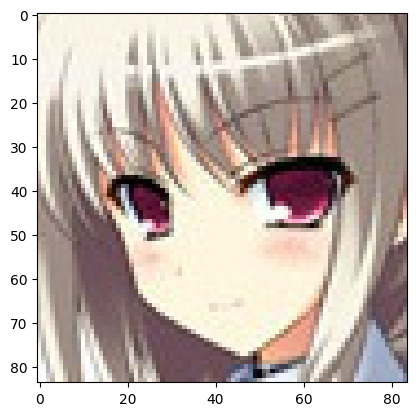

In [ ]:
image = Image.open(IMAGE_DIR + '/42965_2013.jpg')
plt.imshow(image)

In [ ]:
# Scale the image values to range [-1,1], same as the tanh values which the 
# generator is outputting.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMAGE_DIR,
    label_mode=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 23018 files belonging to 1 classes.


In [ ]:
train_ds = train_ds.map(lambda x: (x - 127.5) / 127.5)

In [ ]:
iter = train_ds.as_numpy_iterator()

In [ ]:
print(len(train_ds))

180


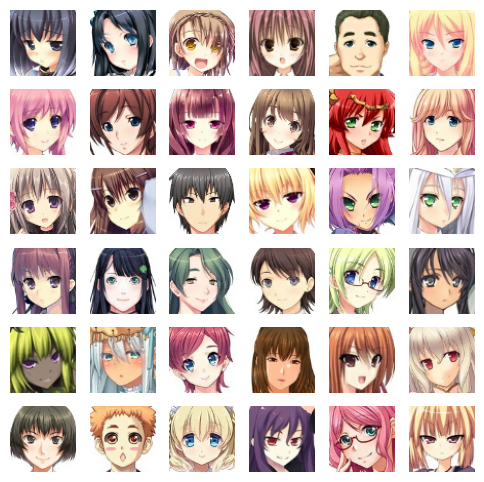

In [ ]:
images = iter.next()

plt.figure(figsize=(6, 6))

for i in range(36):
  plt.subplot(6, 6, i+1)
  plt.imshow((images[i] * 127.5 + 127.5) / 255.0)
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

#### Generator

In [ ]:
noise_dim = 128

In [ ]:
def make_generator(sz):
  n = sz // 16

  model = tf.keras.Sequential()
  model.add(layers.Dense(n*n*1024, use_bias=False, input_shape=(noise_dim,)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((n, n, 1024)))
  assert model.output_shape == (None, n, n, 1024)

  model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, n*2, n*2, 512)
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, n*4, n*4, 256)
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, n*8, n*8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, sz, sz, 3)

  return model


In [ ]:
generator = make_generator(IMAGE_SIZE)

In [ ]:
def init_weights(model):
  for layer in model.layers:
    try:
      layer.set_weights(tf.random.normal(shape=layer.get_weights()[0].shape, mean=0.0, stddev=0.02))
    except:
      continue

In [ ]:
init_weights(generator)

In [ ]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

In [ ]:
generated_image.shape

TensorShape([1, 64, 64, 3])

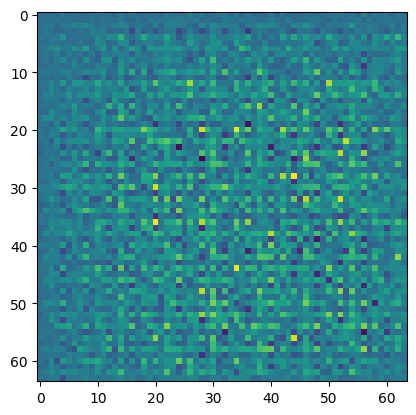

In [ ]:
plt.imshow(generated_image[0,:,:,0])

#### Discriminator

In [ ]:
def make_discriminator():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', use_bias=False,
                          input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
  assert model.output_shape == (None, 32, 32, 64)
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 256)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 4, 4, 512)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(1024, (4, 4), strides=(1, 1), padding='valid', use_bias=False))
  model.add(layers.Flatten())
  model.add(layers.Activation('sigmoid'))

  return model

In [ ]:
discriminator = make_discriminator()
init_weights(discriminator)

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.4999838  0.4999485  0.500006   ... 0.5000056  0.4999662  0.50000167]], shape=(1, 1024), dtype=float32)


### Loss and Optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#### Generator loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Update beta_1 to 0.5 to stabilize training (from paper)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Train model

In [ ]:
checkpoint_dir = 'drive/MyDrive/Colab Notebooks/Projects/GAN project/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
num_examples_to_generate = 36

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return (gen_loss, disc_loss)

In [ ]:
def train(dataset, epochs):
  gen_loss_history = []
  dis_loss_history = []

  for epoch in range(epochs):
    gen_epoch_loss = 0
    dis_epoch_loss = 0
    start = time.time()
    print(f'Epoch: {epoch}')

    for image_batch in tqdm(dataset):
      (gen_loss, disc_loss) = train_step(image_batch)
      gen_epoch_loss += gen_loss
      dis_epoch_loss += disc_loss

    gen_epoch_loss /= len(dataset)
    dis_epoch_loss /= len(dataset)
    
    gen_loss_history.append(gen_epoch_loss)
    dis_loss_history.append(dis_epoch_loss)

    # Produce images for GIF along the way
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Time for epoch {epoch+1} is {time.time()-start} seconds')
    print(f'Generator loss: {gen_epoch_loss:.4f} Discriminator loss: {dis_epoch_loss:.4f}')

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

  return (gen_loss_history, dis_loss_history)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
    plt.subplot(6, 6, i+1)
    plt.imshow((predictions[i,:,:,:] * 127.5 + 127.5) / 255.0)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

  plt.savefig('drive/MyDrive/Colab Notebooks/Projects/GAN project/gifs/' + 'image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

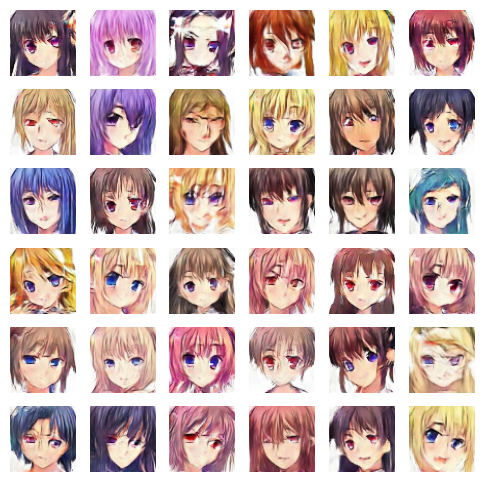

In [ ]:
EPOCHS = 30

(gen_loss_history, dis_loss_history) = train(train_ds, EPOCHS)

### Evaluate model

Graph is the loss for epochs 91 to 120.

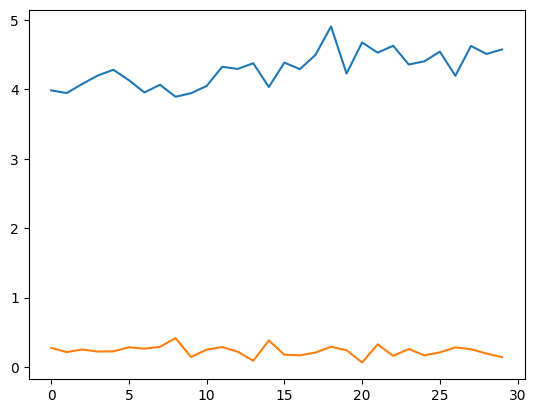

In [ ]:
plt.plot(gen_loss_history, label='generator loss')
plt.plot(dis_loss_history, label='discriminator loss')

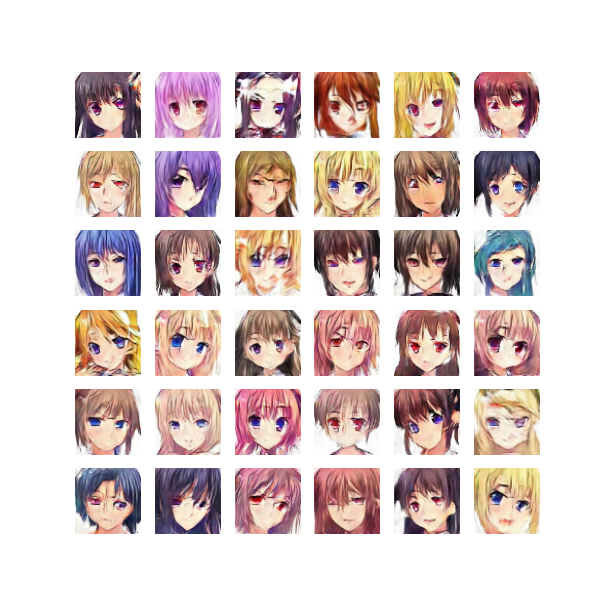

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('drive/MyDrive/Colab Notebooks/Projects/GAN project/gifs/' + 'image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('drive/MyDrive/Colab Notebooks/Projects/GAN project/gifs/' + 'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-40-7f1e45bb281a>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-40-7f1e45bb281a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-32hlgh58
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-32hlgh58
  Resolved https://github.com/tensorflow/docs to commit abfbe6e54864baa38dbb985b984acd304be610d4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=183273 sha256=b46d31ae375ae1fa585843349a53b79464d76060f65459a4e4b59c17ca3ea536
  Stored in directory: /tmp/pip-ephem-wheel-cache-2p5b5c1a/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs



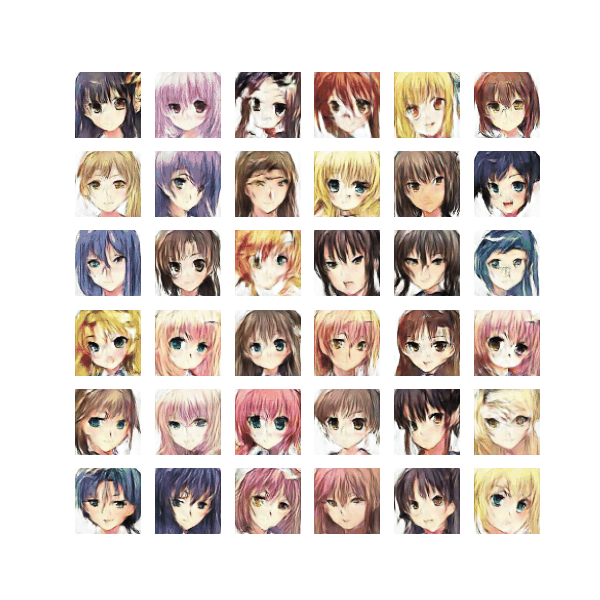

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)